# Sprint 論文読解入門  


＜目的＞  
- 機械学習分野の論文から有益な情報を引き出せるようにする
- これまで扱ってきた領域の論文から新たな知識を得る

以下の論文を読み問題に答えてください。CNNを使った物体検出（Object Detection）の代表的な研究です。

Ren, S., He, K., Girshick, R., Sun, J.: Faster r-cnn: Towards real-time object detection with region proposal networks. In: Advances in neural information processing systems. (2015) 91–99

In [1]:
from IPython.display import Image

### 【問題1】物体検出の分野にはどういった手法が存在したか  
region based CNN (R-CNN) が有名だった。R-CNNの処理には2つの大きな視点、1. 候補領域抽出（Extract region proposals）と、2. CNN特徴の計算（Compute CNN features）の処理パートがある。これは、1 でオブジェクトらしい領域を主にSelective Searchと呼ばれる手法で探し出し、2 でその抽出された領域に対してCNNを適応して特徴抽出し、SVMで分類を行う手法であった。  
Selective Searchでは、領域を小領域へ分割した後、その小領域同士を色のヒストグラムやテクスチャ等で数値化した混合メトリクスで類似度の高いものから結合していき、これを繰り返すことで候補領域の抽出を可能にしている。

(p1, 1.Introduction)  
(p2, 2.Related Work)  

[2] R. Girshick, “Fast R-CNN,” in IEEE International Conference on
Computer Vision (ICCV), 2015.

### 【問題2】 Fasterとあるが、どういった仕組みで高速化したのか
物体検知においては、Selective Seachなどによる候補領域抽出がボトルネックであった。  
著者らのFaster R-CNNでは、この候補領域抽出もニューラルネットワークを使用する。以前のR-CNN（Fast R-CNN）では分類に使用される畳み込み層からの特徴マップが候補領域抽出にも使用できると考え、これを加えた領域検出用のRegion Prorosal Netwark: RPNを学習によって獲得することで、ボトルネックであった候補領域抽出をSelective Searchよりも高い推論速度で実行できるようになった。  

(p.1, 1 INTRODUCTION)

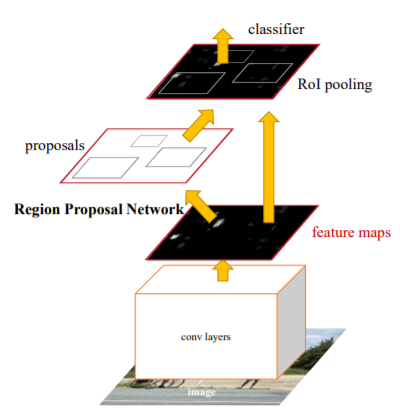

In [2]:
Image("paper-1.png")

個人的な理解では、以前は候補領域の抽出に時間がかかり、さらに提案された複数の領域に対してconvをかけなくてはならなかった。しかし、Faster R-CNN では一度全体にconvをかけ、その特徴マップをもとにRPNでproposalを作成し、以降はRoI poolingで処理できるので速い、ということと思われる。

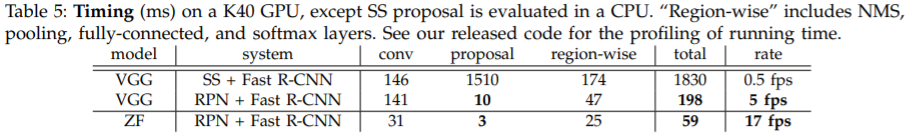

In [3]:
Image("paper-2.png")

- Selective Search + Fast R-CNNと比較し、10倍の速さ（0.5 → 5 frames per second）

### 【問題3】One-Stageの手法とTwo-Stageの手法はどう違うのか  
One-Stage手法の例としてOverFeatが挙げられている。OverFeatもCNNで生成された特徴マップをもとに領域抽出と特定を行っているが、それがある特定のクラスに限定して行われる。  
対してTwo-Stage手法では、領域抽出は特定のクラスに限定せずに行った後、領域の分類を特定のクラスに対して行う。  

OverFeatを模倣して著者らがOne-Stage手法のFast R-CNNを構築し、PASCAL VOC 2007データセットを用いた実験では、Two-Stage手法の方が精度が高かった。同様に他の研究でも、Selective Searchによるクラスによらない領域提案 → 分類（2stage）からSlidingWindowでの領域提案 + 分類（1stage）に置き換えると、最大6%の低下が報告されている。また提案領域の処理数も多くなるため、One-Stage手法はより遅くなる。

(p.10, 4 EXPERIMENTS, One-Stage vs. Two-Stage Proposal + Detection)  

[9] P. Sermanet, D. Eigen, X. Zhang, M. Mathieu, R. Fergus,
and Y. LeCun, “Overfeat: Integrated recognition, localization
and detection using convolutional networks,” in International
Conference on Learning Representations (ICLR), 2014.

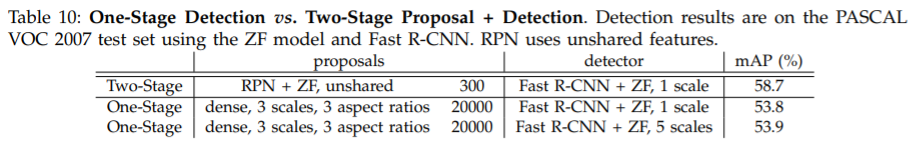

In [4]:
Image("paper-3.png")

### 【問題4】RPNとは何か    
CNNからの特徴マップをもとに、物体の候補領域抽出を行う畳み込みネットワークで、後述するanchorが物体か背景かを予測する分類（$cls$）全結合層と、anchorの座標とサイズを予測する回帰子（$reg$）全結合層をもつ。  
RPNでは、畳み込み層からの出力を受け取り、window-sliding毎に $k$ 通りのanchorを考慮する。$k$ はアスペクト比とサイズの組み合わせで決まり、defaultでは3×3＝9。このanchor毎に候補領域とその中にあるものが物体か否かの予測を行い、物体である可能性の高いbound boxの提案を行う。  

(p.3, 3 FASTER R-CNN, 3.1 Region Proposal Netwaorks)

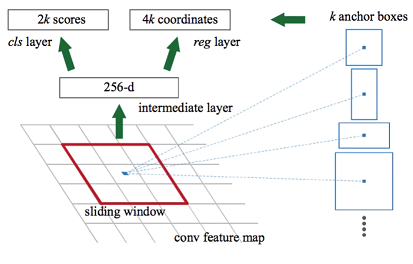

In [5]:
Image("paper-4.png")

### 【問題5】RoIプーリングとは何か    
RoI (Region of Interest) プーリングは、畳み込み層からの様々なサイズの候補領域入力（RoI）に対して最大プーリングを使用し、固定サイズ($H×W$, 例えば7×7）の特徴ベクトルを生成する手法。引用文献[2]では、RoIは左上からの位置($r,c$)と高さ・幅（$h,w$）の4つのタプル($r,c,h,w$)で定義しており、特徴量マップ上の長方形の領域である。この領域を$h/H×w/W$のグリッドに分けて最大プーリングすることで、入力サイズに関わらず固定サイズの特徴ベクトルを生成できる。

(p.6, 3 FASTER R-CNN, 3.2 Sharing Features for RPN and Fast R-CNN(ⅲ))  

[2] R. Girshick, “Fast R-CNN,” in IEEE International Conference on Computer Vision (ICCV), 2015.

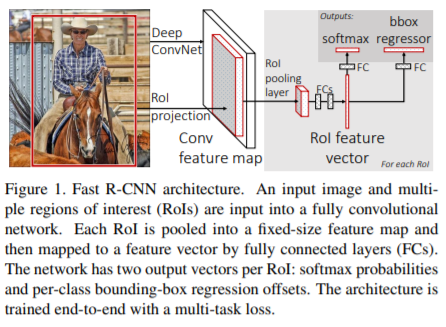

In [6]:
Image("paper-5.png")

### 【問題6】 Anchorのサイズはどうするのが適切か
複数のサイズを設定しておくのが適切。  
PASCAL VOC 2007というデータセットを使用した著者らの実験では、複数のスケール・アスペクト比の設定をもつアンカーで精度が高かった。  
（スケール:3, アスペクト比:1）設定は著者らがdefaultとしている（スケール:3, アスペクト比:3）設定と精度の値がほぼ同じであり、これらは独立な次元で精度に影響を与える事が示唆された。しかし著者らはモデルの柔軟性を保つため、スケールだけではなくアスペクト比についても複数の設定を設けている。

(p.9, 4 EXPERIMENTS  Sensitivities to Hyper-parameters.)

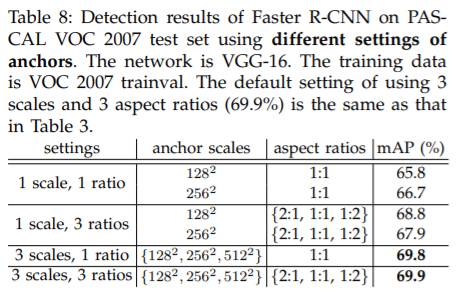

In [7]:
Image("paper-6.png")

### 【問題7】何というデータセットを使い、先行研究に比べどういった指標値が得られているか  
モデルの総合的な評価のため、PASCAL VOC 2007 detection benchmark のデータセットが使用されている。これは20種類以上の物体と背景からなる画像で、5000の訓練/検証セットと5000のテストセットがある。いくつかのモデルについては PASCAL VOC 2012 のデータセットも使用している。  
また、モデルのさらなる学習のため Microsoft COCO データセットも使用している。これは80種類の物体と背景からなり、訓練セットとして80000、検証セットとして40000、テストセットとして20000画像を使用した。

先行研究（SelectiveSearch + Fast R-CNN）と著者らのFaster-CNN（RPN + Fast R-CNN）とで、訓練データを上記の各組み合わせで行い、PASCAL VOC 2007/2012 のテストデータで評価した結果が以下のとおり。

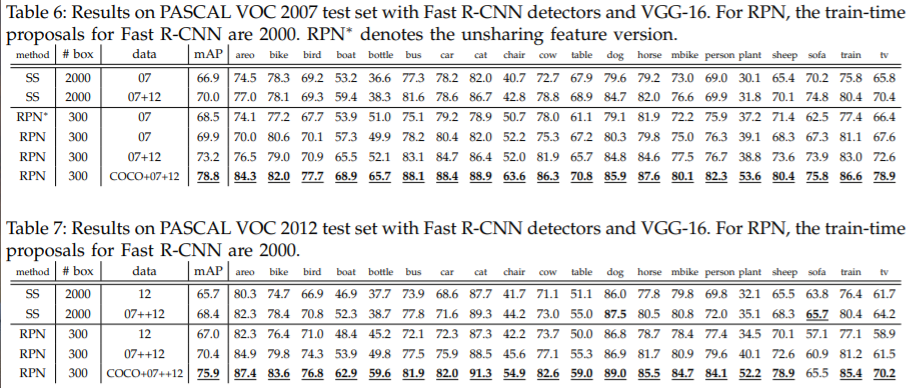

In [6]:
Image("paper-7.png")

＊精度の指標として用いられているのがmAP（mean Average Precision）。  
　APは、m個の正解ラベルが現れた時点で、モデルがm個のラベルの内、どれだけのラベルを検出できているかを平均的に表現したもの。  
　mAPは、全ての時点iにおけるAP(平均適合率)を平均することで、より一般的な平均値を求める為のもの。

先行研究と比較し、同条件では 2007/2012 いずれにおいてもより高いmAPが得られている。  深層学習にとっては大量のデータによる学習が重要であり、COCO データセットも使用することでmAPはさらに向上している。

(p.11, 4 EXPERIMENTS  4.3 From MS COCO to PASCAL VOC)

### 【問題8】Faster R-CNNよりも新しい物体検出の論文では、Faster R-CNNがどう引用されているか  

Kaiming He, Georgia Gkioxari, Piotr Dollár, Ross Girshick : "Mask R-CNN"  
(Computer Vision and Pattern Recognition)

- 「Faster R-CNNは、これを用いた多くの後続する改善に対して柔軟かつ堅牢であり、現在のいくつかのベンチマークにおける先導的なフレームワークである」  

(p.2, 2 RELATED WORK)



- 「最も重要なことは、Faster-RCNNはネットワークの入力と出力の間で、ピクセルレベルの正確な配置を行うようデザインされていなかったことである。これは、特徴抽出の核心を担うRoI Poolingが、粗い空間情報の近似を行う点で、最も明らかである。このピクセルレベルのズレを補正するため、我々はRoI Alignと呼ばれる、単純で近似が含まれず空間情報を正確に保存できるレイヤーを提案する。」… Mask R-CNN の核心部  

(p.1, 1 INTRODUCTION)